# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

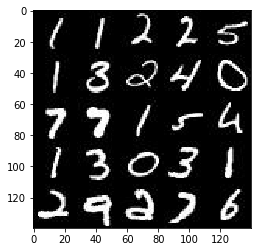

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'))

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

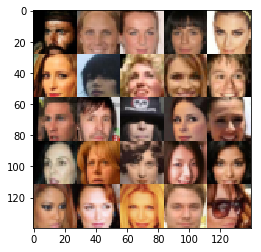

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.3.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    real_input = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='real_input') 
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learn_rate = tf.placeholder(tf.float32)
    return real_input, inputs_z, learn_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Operation'>):
<tf.Operation 'assert_rank_2/Assert/Assert' type=Assert>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
['File "/opt/conda/lib/python3.6/runpy.py", line 193, in _run_module_as_main\n    "__main__", mod_spec)', 'File "/opt/conda/lib/python3.6/runpy.py", line 85, in _run_code\n    exec(code, run_globals)', 'File "/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>\n    app.launch_new_instance()', 'File "/opt/conda/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance\n    app.start()', 'File "/opt/conda/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 478, in start\n    self.io_loop.start()', 'File "/opt/conda/lib/python3.6/site-packages/zmq/eventloop/ioloop.py", line 177, in start\n    super(ZMQIOLoop, self).start()', 'File "/opt/co

### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    alpha = 0.1
    with tf.variable_scope('discriminator', reuse=reuse):
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='SAME')
        x1 = tf.maximum(alpha * x1, x1)
        
        x2 = tf.layers.conv2d(x1, 128, 5, strides=2, padding='SAME')
        x2 = tf.layers.batch_normalization(x2, training=True)
        x2 = tf.maximum(alpha * x2, x2)
        
        x3 = tf.layers.conv2d(x2, 256, 5, strides=2, padding='SAME')
        x3 = tf.layers.batch_normalization(x3, training=True)
        x3 = tf.maximum(alpha * x3, x3)

        flat = tf.reshape(x3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        output = tf.sigmoid(logits)
       
        return output, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    alpha = 0.1
    with tf.variable_scope('generator', reuse=not is_train):
        f1 = tf.layers.dense(z, 7*7*512)
        f1 = tf.reshape(f1, (-1, 7, 7, 512))
        f1 = tf.layers.batch_normalization(f1, training=is_train)
        f1 = tf.maximum(alpha * f1, f1)
        
        x1 = tf.layers.conv2d_transpose(f1, 256, 5, strides=1, padding='SAME')
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        
        x2 = tf.layers.conv2d_transpose(x1, 128, 5, strides=2, padding='SAME')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        
        x3 = tf.layers.conv2d_transpose(x2, 64, 5, strides=1, padding='SAME')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        
        x4 = tf.layers.conv2d_transpose(x3, 32, 5, strides=1, padding='same') 
        x4 = tf.layers.batch_normalization(x4, training=is_train)
        x4 = tf.maximum(alpha * x4, x4)
        
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=2, padding='SAME')
        output = tf.tanh(logits)
        
        return output


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)*0.9))
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    d_loss = d_loss_real + d_loss_fake
    
    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_v = tf.trainable_variables()
    d_variables = [v for v in t_v if v.name.startswith('discriminator')]
    g_variables = [v for v in t_v if v.name.startswith('generator')]

    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_variables)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_variables)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    input_real, input_z, learn_rate = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    steps = 0
    if data_image_mode == "RGB":
        output_channel = 3 
    else:
        output_channel = 1

    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                steps += 1
                batch_images *= 2.0 # -0.5 to -1 & 0.5 to 1

                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                _ = sess.run(d_opt, feed_dict={input_z: batch_z, input_real: batch_images, learn_rate: learning_rate})
                
                _ = sess.run(g_opt, feed_dict={input_z: batch_z, input_real: batch_images, learn_rate: learning_rate})

                if steps % 10 == 0:
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real:batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z, input_real:batch_images})

                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))

                if steps % 50 == 0:
                    show_generator_output(sess, 20, input_z, output_channel, data_image_mode)

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 2.9803... Generator Loss: 0.2808
Epoch 1/2... Discriminator Loss: 1.9996... Generator Loss: 0.5274
Epoch 1/2... Discriminator Loss: 1.6098... Generator Loss: 0.8166
Epoch 1/2... Discriminator Loss: 2.1442... Generator Loss: 0.4368
Epoch 1/2... Discriminator Loss: 2.3807... Generator Loss: 0.3684


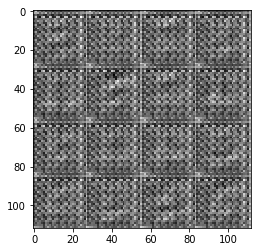

Epoch 1/2... Discriminator Loss: 1.7166... Generator Loss: 0.6318
Epoch 1/2... Discriminator Loss: 1.6628... Generator Loss: 0.6985
Epoch 1/2... Discriminator Loss: 1.7814... Generator Loss: 0.8639
Epoch 1/2... Discriminator Loss: 1.6666... Generator Loss: 0.7869
Epoch 1/2... Discriminator Loss: 1.7052... Generator Loss: 0.5899


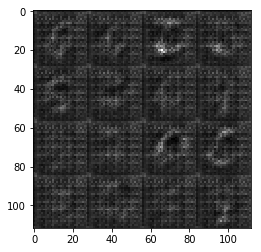

Epoch 1/2... Discriminator Loss: 1.7302... Generator Loss: 0.5235
Epoch 1/2... Discriminator Loss: 1.9058... Generator Loss: 0.2961
Epoch 1/2... Discriminator Loss: 1.5039... Generator Loss: 0.6572
Epoch 1/2... Discriminator Loss: 1.7824... Generator Loss: 0.9294
Epoch 1/2... Discriminator Loss: 1.6205... Generator Loss: 0.7479


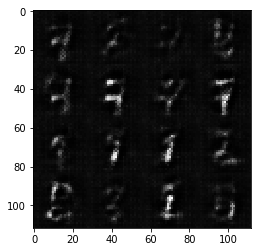

Epoch 1/2... Discriminator Loss: 1.6219... Generator Loss: 0.6472
Epoch 1/2... Discriminator Loss: 1.5297... Generator Loss: 0.4712
Epoch 1/2... Discriminator Loss: 1.5552... Generator Loss: 0.5083
Epoch 1/2... Discriminator Loss: 1.5353... Generator Loss: 0.9321
Epoch 1/2... Discriminator Loss: 1.4925... Generator Loss: 0.6347


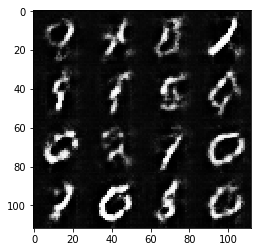

Epoch 1/2... Discriminator Loss: 1.5710... Generator Loss: 0.8611
Epoch 1/2... Discriminator Loss: 1.5961... Generator Loss: 0.6569
Epoch 1/2... Discriminator Loss: 1.6141... Generator Loss: 0.4835
Epoch 1/2... Discriminator Loss: 1.3983... Generator Loss: 0.6628
Epoch 1/2... Discriminator Loss: 1.5510... Generator Loss: 0.5722


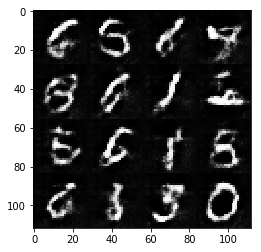

Epoch 1/2... Discriminator Loss: 1.5755... Generator Loss: 0.7223
Epoch 1/2... Discriminator Loss: 1.5311... Generator Loss: 0.5168
Epoch 1/2... Discriminator Loss: 1.6591... Generator Loss: 0.4149
Epoch 1/2... Discriminator Loss: 1.5163... Generator Loss: 0.8970
Epoch 1/2... Discriminator Loss: 1.5379... Generator Loss: 0.5748


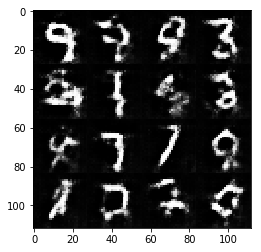

Epoch 1/2... Discriminator Loss: 1.4454... Generator Loss: 0.8012
Epoch 1/2... Discriminator Loss: 1.5727... Generator Loss: 0.7542
Epoch 1/2... Discriminator Loss: 1.5007... Generator Loss: 0.5881
Epoch 1/2... Discriminator Loss: 1.4995... Generator Loss: 0.6227
Epoch 1/2... Discriminator Loss: 1.5083... Generator Loss: 0.7380


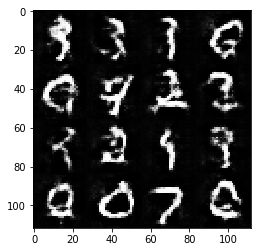

Epoch 1/2... Discriminator Loss: 1.5786... Generator Loss: 0.7631
Epoch 1/2... Discriminator Loss: 1.5064... Generator Loss: 0.6393
Epoch 1/2... Discriminator Loss: 1.5630... Generator Loss: 0.5528
Epoch 1/2... Discriminator Loss: 1.4548... Generator Loss: 0.9213
Epoch 1/2... Discriminator Loss: 1.5580... Generator Loss: 0.8532


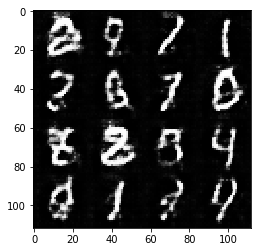

Epoch 1/2... Discriminator Loss: 1.4618... Generator Loss: 0.7140
Epoch 1/2... Discriminator Loss: 1.6097... Generator Loss: 0.4633
Epoch 1/2... Discriminator Loss: 1.4181... Generator Loss: 0.7278
Epoch 1/2... Discriminator Loss: 1.5210... Generator Loss: 0.5387
Epoch 1/2... Discriminator Loss: 1.4769... Generator Loss: 0.6699


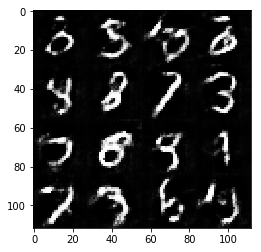

Epoch 1/2... Discriminator Loss: 1.4423... Generator Loss: 0.8594
Epoch 1/2... Discriminator Loss: 1.4739... Generator Loss: 0.7926
Epoch 1/2... Discriminator Loss: 1.4611... Generator Loss: 0.6519
Epoch 1/2... Discriminator Loss: 1.5068... Generator Loss: 0.6391
Epoch 1/2... Discriminator Loss: 1.5685... Generator Loss: 0.4431


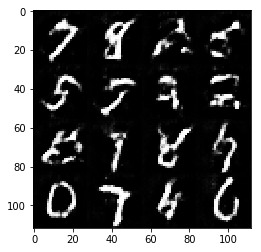

Epoch 1/2... Discriminator Loss: 1.4446... Generator Loss: 0.6672
Epoch 1/2... Discriminator Loss: 1.4628... Generator Loss: 0.6730
Epoch 1/2... Discriminator Loss: 1.5330... Generator Loss: 0.4945
Epoch 1/2... Discriminator Loss: 1.4735... Generator Loss: 0.8507
Epoch 1/2... Discriminator Loss: 1.5132... Generator Loss: 0.5666


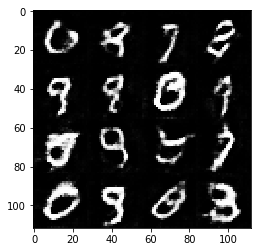

Epoch 1/2... Discriminator Loss: 1.4505... Generator Loss: 0.7364
Epoch 1/2... Discriminator Loss: 1.4369... Generator Loss: 0.6295
Epoch 1/2... Discriminator Loss: 1.5085... Generator Loss: 0.4768
Epoch 1/2... Discriminator Loss: 1.4646... Generator Loss: 0.5599
Epoch 1/2... Discriminator Loss: 1.4518... Generator Loss: 0.6375


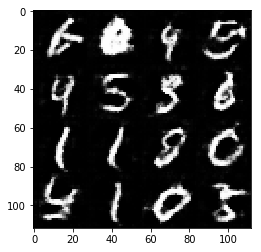

Epoch 1/2... Discriminator Loss: 1.4825... Generator Loss: 0.8203
Epoch 1/2... Discriminator Loss: 1.5277... Generator Loss: 0.4949
Epoch 1/2... Discriminator Loss: 1.4976... Generator Loss: 0.5925
Epoch 1/2... Discriminator Loss: 1.6715... Generator Loss: 0.3827
Epoch 1/2... Discriminator Loss: 1.4161... Generator Loss: 0.7451


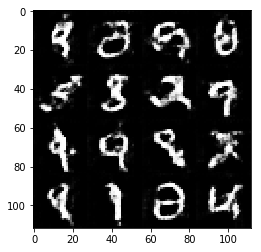

Epoch 1/2... Discriminator Loss: 1.4143... Generator Loss: 0.7490
Epoch 1/2... Discriminator Loss: 1.5078... Generator Loss: 0.6095
Epoch 1/2... Discriminator Loss: 1.4092... Generator Loss: 0.6593
Epoch 1/2... Discriminator Loss: 1.4694... Generator Loss: 0.5973
Epoch 1/2... Discriminator Loss: 1.4595... Generator Loss: 0.5558


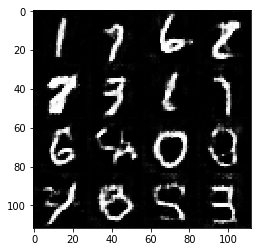

Epoch 1/2... Discriminator Loss: 1.4182... Generator Loss: 0.8475
Epoch 1/2... Discriminator Loss: 1.4787... Generator Loss: 0.5332
Epoch 1/2... Discriminator Loss: 1.6318... Generator Loss: 0.3946
Epoch 1/2... Discriminator Loss: 1.4188... Generator Loss: 0.8418
Epoch 1/2... Discriminator Loss: 1.4539... Generator Loss: 0.6624


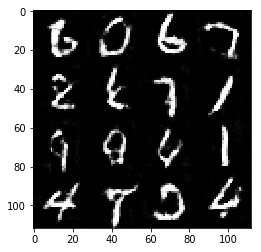

Epoch 1/2... Discriminator Loss: 1.4683... Generator Loss: 0.6743
Epoch 1/2... Discriminator Loss: 2.1312... Generator Loss: 1.9902
Epoch 1/2... Discriminator Loss: 1.4236... Generator Loss: 0.6941
Epoch 1/2... Discriminator Loss: 1.4233... Generator Loss: 0.6710
Epoch 1/2... Discriminator Loss: 1.3939... Generator Loss: 0.7644


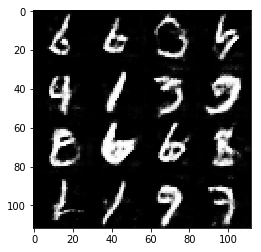

Epoch 1/2... Discriminator Loss: 1.3856... Generator Loss: 0.6636
Epoch 1/2... Discriminator Loss: 1.4170... Generator Loss: 0.7245
Epoch 1/2... Discriminator Loss: 1.4719... Generator Loss: 0.5508
Epoch 1/2... Discriminator Loss: 1.4602... Generator Loss: 0.6041
Epoch 1/2... Discriminator Loss: 1.7163... Generator Loss: 1.1771


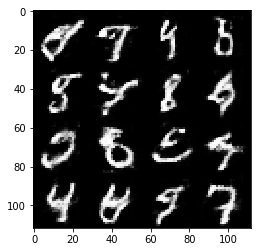

Epoch 1/2... Discriminator Loss: 1.4825... Generator Loss: 0.5626
Epoch 1/2... Discriminator Loss: 1.4740... Generator Loss: 0.6972
Epoch 1/2... Discriminator Loss: 1.4399... Generator Loss: 0.6324
Epoch 1/2... Discriminator Loss: 1.4379... Generator Loss: 0.8147
Epoch 1/2... Discriminator Loss: 1.4955... Generator Loss: 0.6774


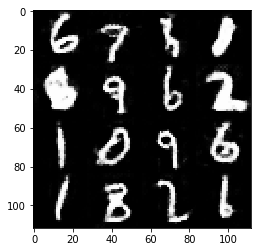

Epoch 1/2... Discriminator Loss: 1.4701... Generator Loss: 0.7509
Epoch 1/2... Discriminator Loss: 1.4547... Generator Loss: 0.6582
Epoch 1/2... Discriminator Loss: 1.4941... Generator Loss: 0.7977
Epoch 2/2... Discriminator Loss: 1.5644... Generator Loss: 0.6090
Epoch 2/2... Discriminator Loss: 1.3704... Generator Loss: 0.7515


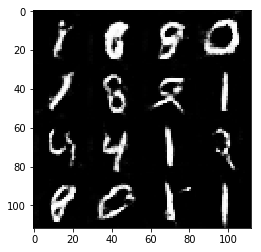

Epoch 2/2... Discriminator Loss: 1.4167... Generator Loss: 0.7956
Epoch 2/2... Discriminator Loss: 1.3709... Generator Loss: 0.7362
Epoch 2/2... Discriminator Loss: 1.4314... Generator Loss: 0.6889
Epoch 2/2... Discriminator Loss: 1.3840... Generator Loss: 0.9039
Epoch 2/2... Discriminator Loss: 1.4270... Generator Loss: 0.8453


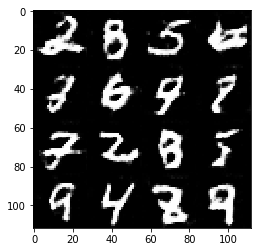

Epoch 2/2... Discriminator Loss: 1.4650... Generator Loss: 0.8136
Epoch 2/2... Discriminator Loss: 1.5564... Generator Loss: 0.5843
Epoch 2/2... Discriminator Loss: 1.4719... Generator Loss: 0.6761
Epoch 2/2... Discriminator Loss: 1.4090... Generator Loss: 0.6781
Epoch 2/2... Discriminator Loss: 1.4560... Generator Loss: 0.5200


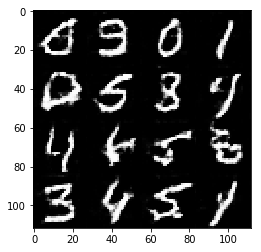

Epoch 2/2... Discriminator Loss: 1.4335... Generator Loss: 0.8517
Epoch 2/2... Discriminator Loss: 1.4759... Generator Loss: 0.6814
Epoch 2/2... Discriminator Loss: 1.5079... Generator Loss: 0.5343
Epoch 2/2... Discriminator Loss: 1.3571... Generator Loss: 0.6497
Epoch 2/2... Discriminator Loss: 1.4275... Generator Loss: 0.9366


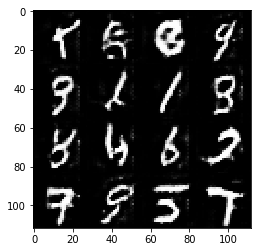

Epoch 2/2... Discriminator Loss: 1.3967... Generator Loss: 0.6938
Epoch 2/2... Discriminator Loss: 1.3762... Generator Loss: 0.6824
Epoch 2/2... Discriminator Loss: 1.6022... Generator Loss: 0.3980
Epoch 2/2... Discriminator Loss: 1.3619... Generator Loss: 0.8443
Epoch 2/2... Discriminator Loss: 1.6879... Generator Loss: 0.3668


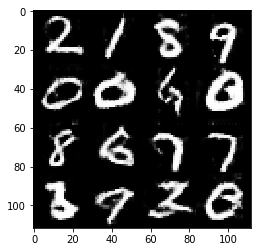

Epoch 2/2... Discriminator Loss: 1.4723... Generator Loss: 0.7485
Epoch 2/2... Discriminator Loss: 1.4377... Generator Loss: 0.6101
Epoch 2/2... Discriminator Loss: 1.4086... Generator Loss: 0.8164
Epoch 2/2... Discriminator Loss: 1.5119... Generator Loss: 0.5302
Epoch 2/2... Discriminator Loss: 1.3686... Generator Loss: 0.7446


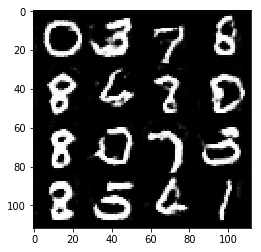

Epoch 2/2... Discriminator Loss: 1.6531... Generator Loss: 0.3731
Epoch 2/2... Discriminator Loss: 1.5253... Generator Loss: 0.5522
Epoch 2/2... Discriminator Loss: 1.4122... Generator Loss: 0.6426
Epoch 2/2... Discriminator Loss: 1.5573... Generator Loss: 0.4472
Epoch 2/2... Discriminator Loss: 1.4939... Generator Loss: 0.8126


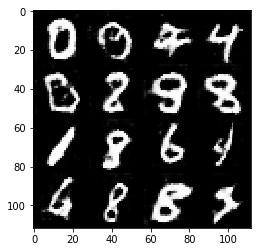

Epoch 2/2... Discriminator Loss: 1.5356... Generator Loss: 0.4773
Epoch 2/2... Discriminator Loss: 1.4233... Generator Loss: 0.7054
Epoch 2/2... Discriminator Loss: 1.3856... Generator Loss: 0.7687
Epoch 2/2... Discriminator Loss: 1.3890... Generator Loss: 0.7431
Epoch 2/2... Discriminator Loss: 1.4276... Generator Loss: 0.5850


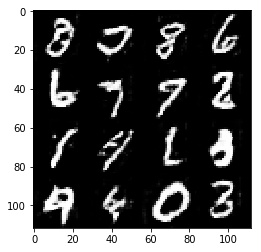

Epoch 2/2... Discriminator Loss: 1.5563... Generator Loss: 0.4689
Epoch 2/2... Discriminator Loss: 1.5467... Generator Loss: 0.4305
Epoch 2/2... Discriminator Loss: 1.3844... Generator Loss: 0.7759
Epoch 2/2... Discriminator Loss: 1.3512... Generator Loss: 0.7649
Epoch 2/2... Discriminator Loss: 1.4709... Generator Loss: 0.7889


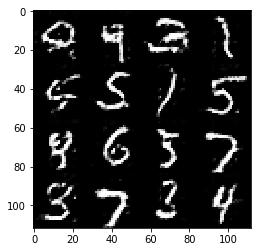

Epoch 2/2... Discriminator Loss: 1.3884... Generator Loss: 0.5784
Epoch 2/2... Discriminator Loss: 1.5360... Generator Loss: 0.6035
Epoch 2/2... Discriminator Loss: 1.5149... Generator Loss: 1.0280
Epoch 2/2... Discriminator Loss: 1.4795... Generator Loss: 0.7575
Epoch 2/2... Discriminator Loss: 1.3627... Generator Loss: 0.6958


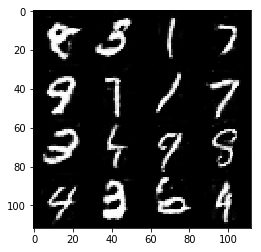

Epoch 2/2... Discriminator Loss: 1.5754... Generator Loss: 0.4050
Epoch 2/2... Discriminator Loss: 1.3855... Generator Loss: 0.6573
Epoch 2/2... Discriminator Loss: 1.4386... Generator Loss: 0.7916
Epoch 2/2... Discriminator Loss: 1.3876... Generator Loss: 0.6034
Epoch 2/2... Discriminator Loss: 1.4246... Generator Loss: 0.6092


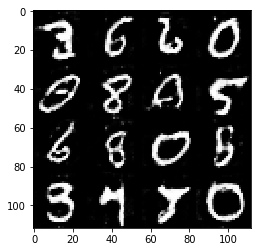

Epoch 2/2... Discriminator Loss: 1.5411... Generator Loss: 0.4691
Epoch 2/2... Discriminator Loss: 1.4816... Generator Loss: 0.5050
Epoch 2/2... Discriminator Loss: 1.3496... Generator Loss: 0.8603
Epoch 2/2... Discriminator Loss: 1.5723... Generator Loss: 0.4674
Epoch 2/2... Discriminator Loss: 1.3880... Generator Loss: 0.7419


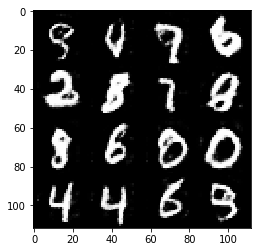

Epoch 2/2... Discriminator Loss: 1.5693... Generator Loss: 0.5411
Epoch 2/2... Discriminator Loss: 1.7243... Generator Loss: 0.3336
Epoch 2/2... Discriminator Loss: 1.3579... Generator Loss: 0.7249
Epoch 2/2... Discriminator Loss: 1.5702... Generator Loss: 0.4326
Epoch 2/2... Discriminator Loss: 1.4959... Generator Loss: 0.5153


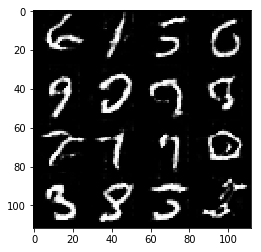

Epoch 2/2... Discriminator Loss: 1.5303... Generator Loss: 0.4963
Epoch 2/2... Discriminator Loss: 1.5061... Generator Loss: 0.7656
Epoch 2/2... Discriminator Loss: 1.4714... Generator Loss: 0.5874
Epoch 2/2... Discriminator Loss: 1.4234... Generator Loss: 0.6369
Epoch 2/2... Discriminator Loss: 1.4611... Generator Loss: 0.9389


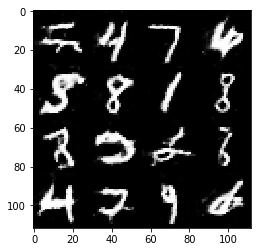

Epoch 2/2... Discriminator Loss: 1.5388... Generator Loss: 0.6150
Epoch 2/2... Discriminator Loss: 1.4221... Generator Loss: 0.9916
Epoch 2/2... Discriminator Loss: 1.5032... Generator Loss: 0.6342
Epoch 2/2... Discriminator Loss: 1.3884... Generator Loss: 0.8746
Epoch 2/2... Discriminator Loss: 1.6378... Generator Loss: 1.1678


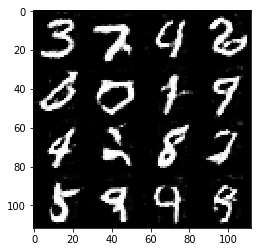

Epoch 2/2... Discriminator Loss: 1.5128... Generator Loss: 0.6378
Epoch 2/2... Discriminator Loss: 1.3411... Generator Loss: 0.6879
Epoch 2/2... Discriminator Loss: 1.4196... Generator Loss: 0.6124
Epoch 2/2... Discriminator Loss: 1.4578... Generator Loss: 1.2100
Epoch 2/2... Discriminator Loss: 1.3998... Generator Loss: 0.6940


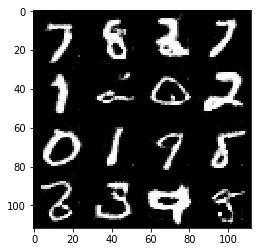

Epoch 2/2... Discriminator Loss: 1.4614... Generator Loss: 0.4988
Epoch 2/2... Discriminator Loss: 1.3219... Generator Loss: 0.9020
Epoch 2/2... Discriminator Loss: 1.3030... Generator Loss: 0.8827
Epoch 2/2... Discriminator Loss: 1.6781... Generator Loss: 0.3655
Epoch 2/2... Discriminator Loss: 1.6349... Generator Loss: 0.4546


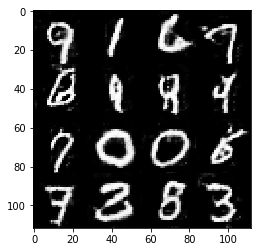

Epoch 2/2... Discriminator Loss: 1.3581... Generator Loss: 0.7995
Epoch 2/2... Discriminator Loss: 1.3553... Generator Loss: 0.7081
Epoch 2/2... Discriminator Loss: 1.5202... Generator Loss: 0.4448
Epoch 2/2... Discriminator Loss: 1.4823... Generator Loss: 0.4995
Epoch 2/2... Discriminator Loss: 1.8779... Generator Loss: 0.2844


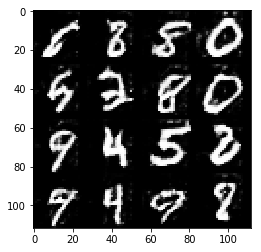

Epoch 2/2... Discriminator Loss: 1.4034... Generator Loss: 0.6441
Epoch 2/2... Discriminator Loss: 1.3944... Generator Loss: 0.9296
Epoch 2/2... Discriminator Loss: 1.3635... Generator Loss: 0.6600
Epoch 2/2... Discriminator Loss: 1.3597... Generator Loss: 0.6314
Epoch 2/2... Discriminator Loss: 1.4033... Generator Loss: 0.5807


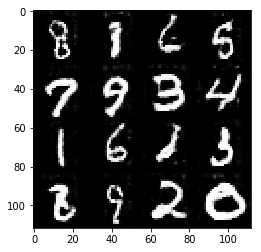

Epoch 2/2... Discriminator Loss: 1.4496... Generator Loss: 0.5559
Epoch 2/2... Discriminator Loss: 1.4791... Generator Loss: 0.5446


In [12]:
batch_size = 64
z_dim = 100
learning_rate = 0.0005
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 5.7469... Generator Loss: 0.0257
Epoch 1/1... Discriminator Loss: 3.0490... Generator Loss: 0.3500
Epoch 1/1... Discriminator Loss: 2.7549... Generator Loss: 0.3668
Epoch 1/1... Discriminator Loss: 2.3331... Generator Loss: 0.3865
Epoch 1/1... Discriminator Loss: 2.2202... Generator Loss: 0.4378


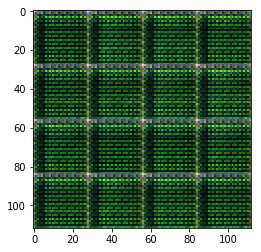

Epoch 1/1... Discriminator Loss: 2.5408... Generator Loss: 0.4737
Epoch 1/1... Discriminator Loss: 1.8948... Generator Loss: 0.5293
Epoch 1/1... Discriminator Loss: 1.5553... Generator Loss: 0.7009
Epoch 1/1... Discriminator Loss: 2.1097... Generator Loss: 0.4599
Epoch 1/1... Discriminator Loss: 1.5061... Generator Loss: 0.7195


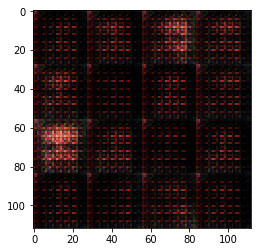

Epoch 1/1... Discriminator Loss: 1.7604... Generator Loss: 0.6364
Epoch 1/1... Discriminator Loss: 2.3050... Generator Loss: 0.3493
Epoch 1/1... Discriminator Loss: 1.6607... Generator Loss: 0.5620
Epoch 1/1... Discriminator Loss: 1.5591... Generator Loss: 0.7151
Epoch 1/1... Discriminator Loss: 1.5763... Generator Loss: 0.7110


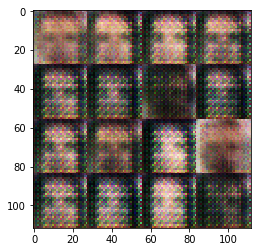

Epoch 1/1... Discriminator Loss: 1.5400... Generator Loss: 0.7789
Epoch 1/1... Discriminator Loss: 2.0350... Generator Loss: 0.5272
Epoch 1/1... Discriminator Loss: 1.5638... Generator Loss: 0.6779
Epoch 1/1... Discriminator Loss: 1.6917... Generator Loss: 0.6762
Epoch 1/1... Discriminator Loss: 1.5965... Generator Loss: 0.6213


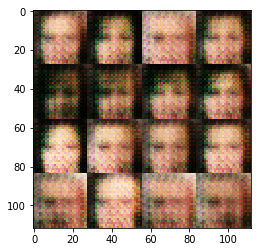

Epoch 1/1... Discriminator Loss: 1.6172... Generator Loss: 0.6698
Epoch 1/1... Discriminator Loss: 1.6006... Generator Loss: 0.7006
Epoch 1/1... Discriminator Loss: 1.5484... Generator Loss: 0.6815
Epoch 1/1... Discriminator Loss: 1.6143... Generator Loss: 0.6844
Epoch 1/1... Discriminator Loss: 1.5317... Generator Loss: 0.7842


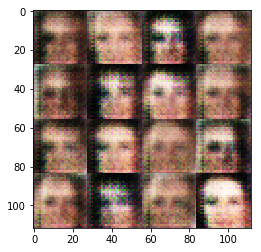

Epoch 1/1... Discriminator Loss: 1.6698... Generator Loss: 0.6779
Epoch 1/1... Discriminator Loss: 1.5292... Generator Loss: 0.7030
Epoch 1/1... Discriminator Loss: 1.5476... Generator Loss: 0.7017
Epoch 1/1... Discriminator Loss: 1.5811... Generator Loss: 0.6939
Epoch 1/1... Discriminator Loss: 1.5268... Generator Loss: 0.7529


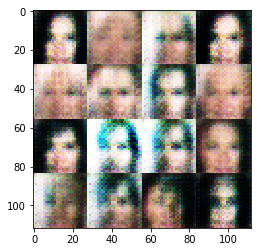

Epoch 1/1... Discriminator Loss: 1.4906... Generator Loss: 0.7301
Epoch 1/1... Discriminator Loss: 1.4975... Generator Loss: 0.7541
Epoch 1/1... Discriminator Loss: 1.4437... Generator Loss: 0.7427
Epoch 1/1... Discriminator Loss: 1.5451... Generator Loss: 0.7645
Epoch 1/1... Discriminator Loss: 1.5546... Generator Loss: 0.6995


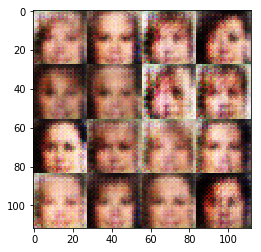

Epoch 1/1... Discriminator Loss: 1.5600... Generator Loss: 0.6873
Epoch 1/1... Discriminator Loss: 1.5242... Generator Loss: 0.6794
Epoch 1/1... Discriminator Loss: 1.5356... Generator Loss: 0.7183
Epoch 1/1... Discriminator Loss: 1.4705... Generator Loss: 0.7480
Epoch 1/1... Discriminator Loss: 1.5605... Generator Loss: 0.7090


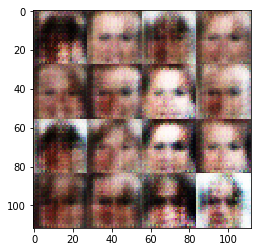

Epoch 1/1... Discriminator Loss: 1.5724... Generator Loss: 0.6648
Epoch 1/1... Discriminator Loss: 1.4455... Generator Loss: 0.7787
Epoch 1/1... Discriminator Loss: 1.6945... Generator Loss: 0.6402
Epoch 1/1... Discriminator Loss: 1.5311... Generator Loss: 0.6843
Epoch 1/1... Discriminator Loss: 1.4420... Generator Loss: 0.7277


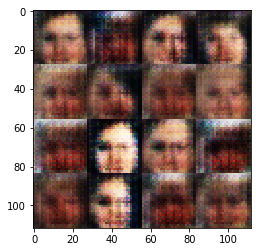

Epoch 1/1... Discriminator Loss: 1.5276... Generator Loss: 0.6917
Epoch 1/1... Discriminator Loss: 1.4228... Generator Loss: 0.7730
Epoch 1/1... Discriminator Loss: 1.4897... Generator Loss: 0.7301
Epoch 1/1... Discriminator Loss: 1.4464... Generator Loss: 0.7713
Epoch 1/1... Discriminator Loss: 1.4956... Generator Loss: 0.7089


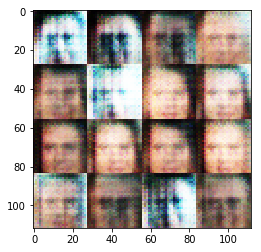

Epoch 1/1... Discriminator Loss: 1.4528... Generator Loss: 0.7711
Epoch 1/1... Discriminator Loss: 1.4739... Generator Loss: 0.7503
Epoch 1/1... Discriminator Loss: 1.5676... Generator Loss: 0.7284
Epoch 1/1... Discriminator Loss: 1.4567... Generator Loss: 0.7225
Epoch 1/1... Discriminator Loss: 1.3960... Generator Loss: 0.7708


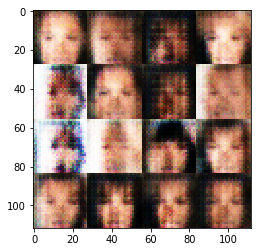

Epoch 1/1... Discriminator Loss: 1.4919... Generator Loss: 0.6880
Epoch 1/1... Discriminator Loss: 1.3814... Generator Loss: 0.8333
Epoch 1/1... Discriminator Loss: 1.4693... Generator Loss: 0.6914
Epoch 1/1... Discriminator Loss: 1.4353... Generator Loss: 0.7679
Epoch 1/1... Discriminator Loss: 1.4250... Generator Loss: 0.7718


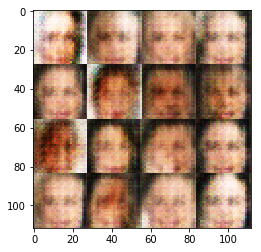

Epoch 1/1... Discriminator Loss: 1.4370... Generator Loss: 0.7316
Epoch 1/1... Discriminator Loss: 1.4487... Generator Loss: 0.7310
Epoch 1/1... Discriminator Loss: 1.4760... Generator Loss: 0.7748
Epoch 1/1... Discriminator Loss: 1.4653... Generator Loss: 0.6863
Epoch 1/1... Discriminator Loss: 1.4644... Generator Loss: 0.7437


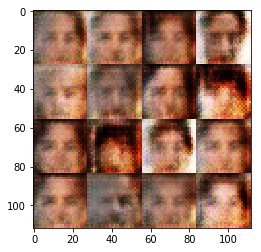

Epoch 1/1... Discriminator Loss: 1.4683... Generator Loss: 0.7883
Epoch 1/1... Discriminator Loss: 1.4407... Generator Loss: 0.6966
Epoch 1/1... Discriminator Loss: 1.5807... Generator Loss: 0.7198
Epoch 1/1... Discriminator Loss: 1.5646... Generator Loss: 0.6675
Epoch 1/1... Discriminator Loss: 1.4914... Generator Loss: 0.7128


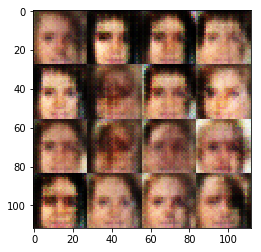

Epoch 1/1... Discriminator Loss: 1.4410... Generator Loss: 0.7252
Epoch 1/1... Discriminator Loss: 1.5553... Generator Loss: 0.7208
Epoch 1/1... Discriminator Loss: 1.4814... Generator Loss: 0.6962
Epoch 1/1... Discriminator Loss: 1.4752... Generator Loss: 0.6986
Epoch 1/1... Discriminator Loss: 1.3957... Generator Loss: 0.7805


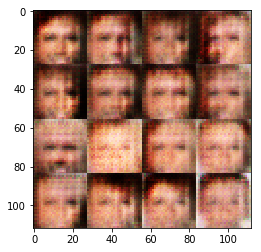

Epoch 1/1... Discriminator Loss: 1.5070... Generator Loss: 0.7612
Epoch 1/1... Discriminator Loss: 1.4654... Generator Loss: 0.7819
Epoch 1/1... Discriminator Loss: 1.4352... Generator Loss: 0.8211
Epoch 1/1... Discriminator Loss: 1.5199... Generator Loss: 0.7554
Epoch 1/1... Discriminator Loss: 1.4396... Generator Loss: 0.7426


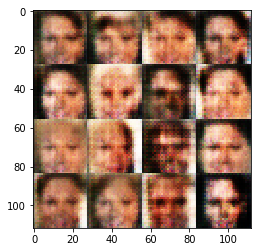

Epoch 1/1... Discriminator Loss: 1.4184... Generator Loss: 0.7276
Epoch 1/1... Discriminator Loss: 1.4273... Generator Loss: 0.7428
Epoch 1/1... Discriminator Loss: 1.5031... Generator Loss: 0.7506
Epoch 1/1... Discriminator Loss: 1.4294... Generator Loss: 0.8095
Epoch 1/1... Discriminator Loss: 1.4179... Generator Loss: 0.7555


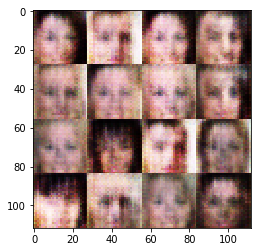

Epoch 1/1... Discriminator Loss: 1.4001... Generator Loss: 0.7140
Epoch 1/1... Discriminator Loss: 1.4037... Generator Loss: 0.7732
Epoch 1/1... Discriminator Loss: 1.4969... Generator Loss: 0.7685
Epoch 1/1... Discriminator Loss: 1.4113... Generator Loss: 0.7929
Epoch 1/1... Discriminator Loss: 1.4116... Generator Loss: 0.7128


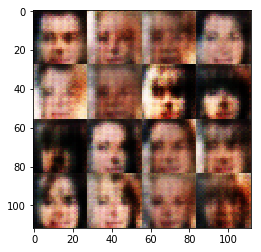

Epoch 1/1... Discriminator Loss: 1.4057... Generator Loss: 0.7406
Epoch 1/1... Discriminator Loss: 1.4724... Generator Loss: 0.7635
Epoch 1/1... Discriminator Loss: 1.4125... Generator Loss: 0.8173
Epoch 1/1... Discriminator Loss: 1.4300... Generator Loss: 0.8266
Epoch 1/1... Discriminator Loss: 1.4175... Generator Loss: 0.7614


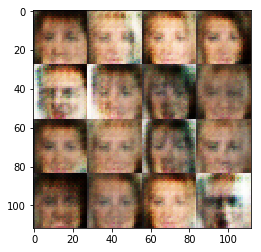

Epoch 1/1... Discriminator Loss: 1.4694... Generator Loss: 0.7885
Epoch 1/1... Discriminator Loss: 1.4157... Generator Loss: 0.7912
Epoch 1/1... Discriminator Loss: 1.4263... Generator Loss: 0.7818
Epoch 1/1... Discriminator Loss: 1.4113... Generator Loss: 0.7365
Epoch 1/1... Discriminator Loss: 1.4521... Generator Loss: 0.7479


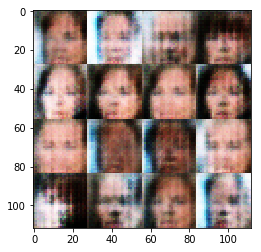

Epoch 1/1... Discriminator Loss: 1.4047... Generator Loss: 0.7853
Epoch 1/1... Discriminator Loss: 1.4142... Generator Loss: 0.7681
Epoch 1/1... Discriminator Loss: 1.4257... Generator Loss: 0.7677
Epoch 1/1... Discriminator Loss: 1.4454... Generator Loss: 0.8071
Epoch 1/1... Discriminator Loss: 1.4217... Generator Loss: 0.8096


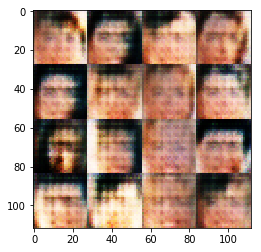

Epoch 1/1... Discriminator Loss: 1.4507... Generator Loss: 0.7104
Epoch 1/1... Discriminator Loss: 1.3800... Generator Loss: 0.7885
Epoch 1/1... Discriminator Loss: 1.4132... Generator Loss: 0.7969
Epoch 1/1... Discriminator Loss: 1.4440... Generator Loss: 0.7019
Epoch 1/1... Discriminator Loss: 1.4409... Generator Loss: 0.7345


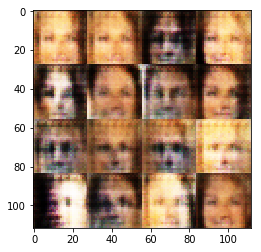

Epoch 1/1... Discriminator Loss: 1.3755... Generator Loss: 0.8117
Epoch 1/1... Discriminator Loss: 1.4107... Generator Loss: 0.7750
Epoch 1/1... Discriminator Loss: 1.4566... Generator Loss: 0.7246
Epoch 1/1... Discriminator Loss: 1.4114... Generator Loss: 0.7185
Epoch 1/1... Discriminator Loss: 1.4183... Generator Loss: 0.7555


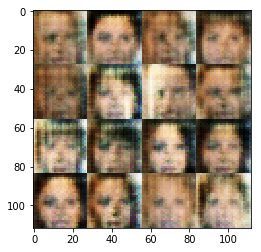

Epoch 1/1... Discriminator Loss: 1.4160... Generator Loss: 0.7909
Epoch 1/1... Discriminator Loss: 1.4370... Generator Loss: 0.8260
Epoch 1/1... Discriminator Loss: 1.4140... Generator Loss: 0.7583
Epoch 1/1... Discriminator Loss: 1.4438... Generator Loss: 0.7083
Epoch 1/1... Discriminator Loss: 1.4343... Generator Loss: 0.8063


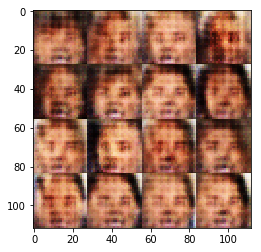

Epoch 1/1... Discriminator Loss: 1.4156... Generator Loss: 0.7350
Epoch 1/1... Discriminator Loss: 1.4484... Generator Loss: 0.7610
Epoch 1/1... Discriminator Loss: 1.4837... Generator Loss: 0.7564
Epoch 1/1... Discriminator Loss: 1.5062... Generator Loss: 0.7769
Epoch 1/1... Discriminator Loss: 1.4559... Generator Loss: 0.7449


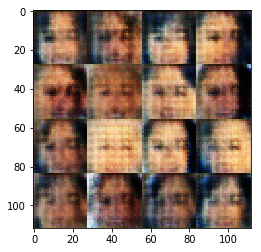

Epoch 1/1... Discriminator Loss: 1.4078... Generator Loss: 0.7527
Epoch 1/1... Discriminator Loss: 1.4479... Generator Loss: 0.8203
Epoch 1/1... Discriminator Loss: 1.3713... Generator Loss: 0.7636
Epoch 1/1... Discriminator Loss: 1.4402... Generator Loss: 0.7745
Epoch 1/1... Discriminator Loss: 1.4589... Generator Loss: 0.7421


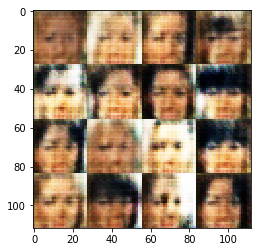

Epoch 1/1... Discriminator Loss: 1.4465... Generator Loss: 0.7629
Epoch 1/1... Discriminator Loss: 1.4122... Generator Loss: 0.8521
Epoch 1/1... Discriminator Loss: 1.4342... Generator Loss: 0.8250
Epoch 1/1... Discriminator Loss: 1.4209... Generator Loss: 0.7840
Epoch 1/1... Discriminator Loss: 1.4107... Generator Loss: 0.7073


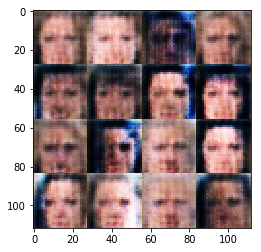

Epoch 1/1... Discriminator Loss: 1.3905... Generator Loss: 0.7826
Epoch 1/1... Discriminator Loss: 1.4164... Generator Loss: 0.7569
Epoch 1/1... Discriminator Loss: 1.4547... Generator Loss: 0.7062
Epoch 1/1... Discriminator Loss: 1.4393... Generator Loss: 0.7545
Epoch 1/1... Discriminator Loss: 1.4371... Generator Loss: 0.7350


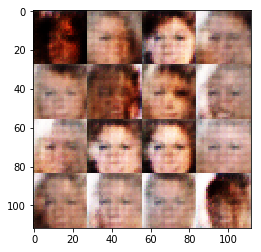

Epoch 1/1... Discriminator Loss: 1.3956... Generator Loss: 0.7005
Epoch 1/1... Discriminator Loss: 1.4436... Generator Loss: 0.7281
Epoch 1/1... Discriminator Loss: 1.4171... Generator Loss: 0.7751
Epoch 1/1... Discriminator Loss: 1.4038... Generator Loss: 0.7153
Epoch 1/1... Discriminator Loss: 1.4371... Generator Loss: 0.7414


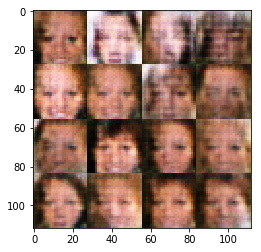

Epoch 1/1... Discriminator Loss: 1.4144... Generator Loss: 0.7545
Epoch 1/1... Discriminator Loss: 1.4062... Generator Loss: 0.7959
Epoch 1/1... Discriminator Loss: 1.4197... Generator Loss: 0.7630
Epoch 1/1... Discriminator Loss: 1.4198... Generator Loss: 0.7425
Epoch 1/1... Discriminator Loss: 1.4042... Generator Loss: 0.8107


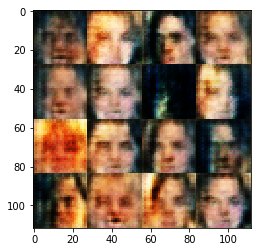

Epoch 1/1... Discriminator Loss: 1.4064... Generator Loss: 0.7570
Epoch 1/1... Discriminator Loss: 1.4681... Generator Loss: 0.7295
Epoch 1/1... Discriminator Loss: 1.4371... Generator Loss: 0.7927
Epoch 1/1... Discriminator Loss: 1.4049... Generator Loss: 0.7807
Epoch 1/1... Discriminator Loss: 1.3796... Generator Loss: 0.8235


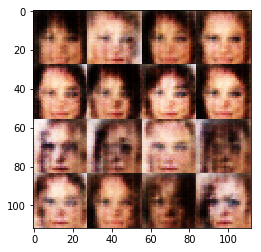

Epoch 1/1... Discriminator Loss: 1.3839... Generator Loss: 0.8726
Epoch 1/1... Discriminator Loss: 1.3660... Generator Loss: 0.7704
Epoch 1/1... Discriminator Loss: 1.3833... Generator Loss: 0.7524
Epoch 1/1... Discriminator Loss: 1.3968... Generator Loss: 0.7317
Epoch 1/1... Discriminator Loss: 1.4337... Generator Loss: 0.8734


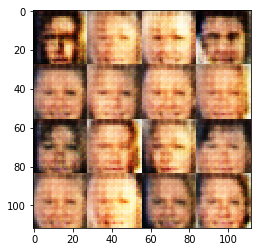

Epoch 1/1... Discriminator Loss: 1.4156... Generator Loss: 0.7874
Epoch 1/1... Discriminator Loss: 1.4971... Generator Loss: 0.6365
Epoch 1/1... Discriminator Loss: 1.3778... Generator Loss: 0.7605
Epoch 1/1... Discriminator Loss: 1.4665... Generator Loss: 0.8196
Epoch 1/1... Discriminator Loss: 1.4187... Generator Loss: 0.7530


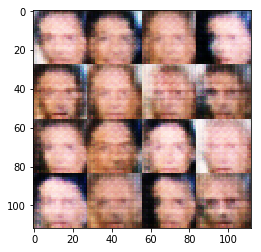

Epoch 1/1... Discriminator Loss: 1.4197... Generator Loss: 0.8442
Epoch 1/1... Discriminator Loss: 1.4559... Generator Loss: 0.6734
Epoch 1/1... Discriminator Loss: 1.4297... Generator Loss: 0.8171
Epoch 1/1... Discriminator Loss: 1.4360... Generator Loss: 0.8467
Epoch 1/1... Discriminator Loss: 1.4229... Generator Loss: 0.7284


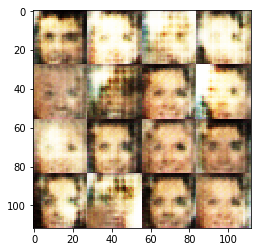

Epoch 1/1... Discriminator Loss: 1.4327... Generator Loss: 0.7022
Epoch 1/1... Discriminator Loss: 1.3758... Generator Loss: 0.8294
Epoch 1/1... Discriminator Loss: 1.4717... Generator Loss: 0.8222
Epoch 1/1... Discriminator Loss: 1.3989... Generator Loss: 0.7546
Epoch 1/1... Discriminator Loss: 1.4472... Generator Loss: 0.7314


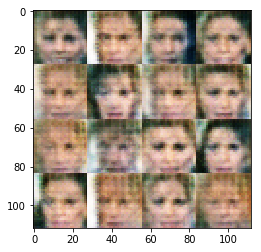

Epoch 1/1... Discriminator Loss: 1.4679... Generator Loss: 0.7341
Epoch 1/1... Discriminator Loss: 1.3820... Generator Loss: 0.7937
Epoch 1/1... Discriminator Loss: 1.4913... Generator Loss: 0.7365
Epoch 1/1... Discriminator Loss: 1.4238... Generator Loss: 0.7905
Epoch 1/1... Discriminator Loss: 1.4136... Generator Loss: 0.8492


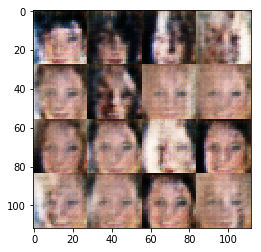

Epoch 1/1... Discriminator Loss: 1.3822... Generator Loss: 0.7570
Epoch 1/1... Discriminator Loss: 1.4670... Generator Loss: 0.7666
Epoch 1/1... Discriminator Loss: 1.4082... Generator Loss: 0.7547
Epoch 1/1... Discriminator Loss: 1.4041... Generator Loss: 0.7861
Epoch 1/1... Discriminator Loss: 1.4177... Generator Loss: 0.7982


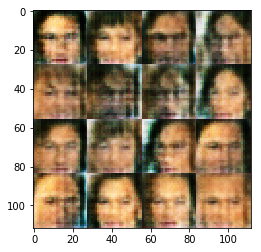

Epoch 1/1... Discriminator Loss: 1.4305... Generator Loss: 0.8436
Epoch 1/1... Discriminator Loss: 1.4414... Generator Loss: 0.7528
Epoch 1/1... Discriminator Loss: 1.4386... Generator Loss: 0.6970
Epoch 1/1... Discriminator Loss: 1.4278... Generator Loss: 0.7936
Epoch 1/1... Discriminator Loss: 1.3872... Generator Loss: 0.7502


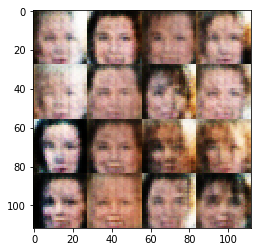

Epoch 1/1... Discriminator Loss: 1.4462... Generator Loss: 0.8373
Epoch 1/1... Discriminator Loss: 1.4227... Generator Loss: 0.7217
Epoch 1/1... Discriminator Loss: 1.4252... Generator Loss: 0.7425
Epoch 1/1... Discriminator Loss: 1.3971... Generator Loss: 0.9094
Epoch 1/1... Discriminator Loss: 1.3933... Generator Loss: 0.7628


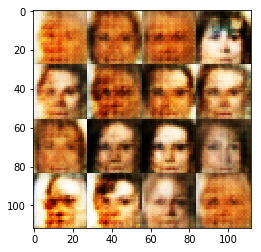

Epoch 1/1... Discriminator Loss: 1.4444... Generator Loss: 0.7533
Epoch 1/1... Discriminator Loss: 1.4004... Generator Loss: 0.7218
Epoch 1/1... Discriminator Loss: 1.4306... Generator Loss: 0.7284
Epoch 1/1... Discriminator Loss: 1.4126... Generator Loss: 0.7130
Epoch 1/1... Discriminator Loss: 1.4250... Generator Loss: 0.6892


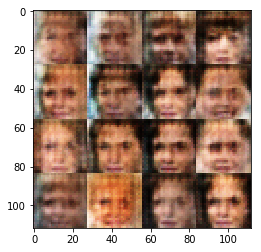

Epoch 1/1... Discriminator Loss: 1.4240... Generator Loss: 0.7590
Epoch 1/1... Discriminator Loss: 1.4347... Generator Loss: 0.8445
Epoch 1/1... Discriminator Loss: 1.4161... Generator Loss: 0.7203
Epoch 1/1... Discriminator Loss: 1.4039... Generator Loss: 0.7412
Epoch 1/1... Discriminator Loss: 1.3917... Generator Loss: 0.8060


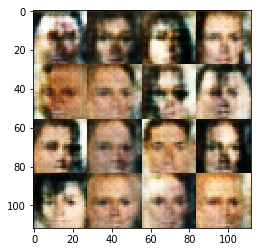

Epoch 1/1... Discriminator Loss: 1.4231... Generator Loss: 0.8088
Epoch 1/1... Discriminator Loss: 1.3886... Generator Loss: 0.8355
Epoch 1/1... Discriminator Loss: 1.4288... Generator Loss: 0.7851
Epoch 1/1... Discriminator Loss: 1.4019... Generator Loss: 0.7555
Epoch 1/1... Discriminator Loss: 1.4441... Generator Loss: 0.7150


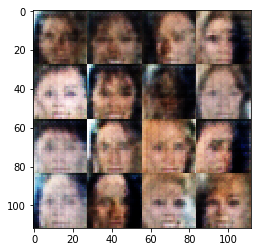

Epoch 1/1... Discriminator Loss: 1.3986... Generator Loss: 0.7098
Epoch 1/1... Discriminator Loss: 1.4093... Generator Loss: 0.7853
Epoch 1/1... Discriminator Loss: 1.4292... Generator Loss: 0.6849
Epoch 1/1... Discriminator Loss: 1.4182... Generator Loss: 0.7377
Epoch 1/1... Discriminator Loss: 1.4200... Generator Loss: 0.6769


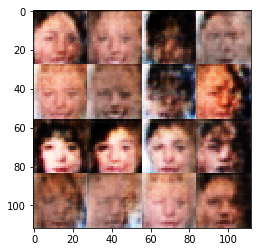

Epoch 1/1... Discriminator Loss: 1.4229... Generator Loss: 0.8483
Epoch 1/1... Discriminator Loss: 1.3948... Generator Loss: 0.8767
Epoch 1/1... Discriminator Loss: 1.4050... Generator Loss: 0.7377
Epoch 1/1... Discriminator Loss: 1.4115... Generator Loss: 0.8330
Epoch 1/1... Discriminator Loss: 1.4382... Generator Loss: 0.7042


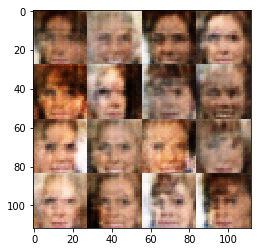

Epoch 1/1... Discriminator Loss: 1.3960... Generator Loss: 0.8305
Epoch 1/1... Discriminator Loss: 1.4214... Generator Loss: 0.6870
Epoch 1/1... Discriminator Loss: 1.4148... Generator Loss: 0.7626
Epoch 1/1... Discriminator Loss: 1.4093... Generator Loss: 0.7478
Epoch 1/1... Discriminator Loss: 1.3842... Generator Loss: 0.7755


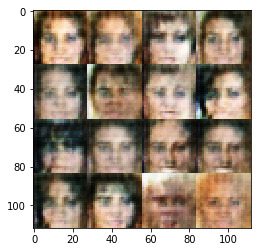

Epoch 1/1... Discriminator Loss: 1.3837... Generator Loss: 0.7730
Epoch 1/1... Discriminator Loss: 1.4385... Generator Loss: 0.7128
Epoch 1/1... Discriminator Loss: 1.3966... Generator Loss: 0.7457
Epoch 1/1... Discriminator Loss: 1.3985... Generator Loss: 0.7341
Epoch 1/1... Discriminator Loss: 1.4066... Generator Loss: 0.8438


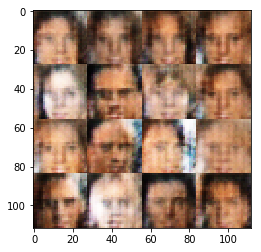

Epoch 1/1... Discriminator Loss: 1.4293... Generator Loss: 0.7310
Epoch 1/1... Discriminator Loss: 1.3880... Generator Loss: 0.8603
Epoch 1/1... Discriminator Loss: 1.3909... Generator Loss: 0.7864
Epoch 1/1... Discriminator Loss: 1.4190... Generator Loss: 0.8997
Epoch 1/1... Discriminator Loss: 1.4345... Generator Loss: 0.8055


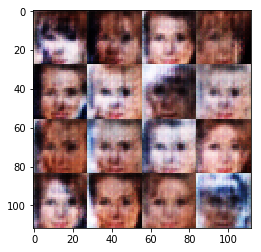

Epoch 1/1... Discriminator Loss: 1.4111... Generator Loss: 0.7331
Epoch 1/1... Discriminator Loss: 1.4513... Generator Loss: 0.8899
Epoch 1/1... Discriminator Loss: 1.4385... Generator Loss: 0.6672
Epoch 1/1... Discriminator Loss: 1.4253... Generator Loss: 0.8383
Epoch 1/1... Discriminator Loss: 1.4508... Generator Loss: 0.7078


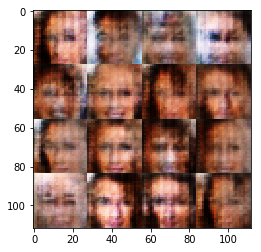

Epoch 1/1... Discriminator Loss: 1.3811... Generator Loss: 0.7588
Epoch 1/1... Discriminator Loss: 1.3897... Generator Loss: 0.8677
Epoch 1/1... Discriminator Loss: 1.4046... Generator Loss: 0.7253
Epoch 1/1... Discriminator Loss: 1.3738... Generator Loss: 0.7685
Epoch 1/1... Discriminator Loss: 1.4115... Generator Loss: 0.7909


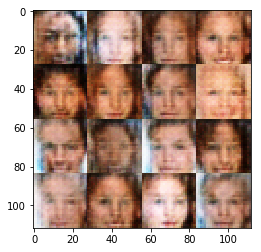

Epoch 1/1... Discriminator Loss: 1.4156... Generator Loss: 0.7438
Epoch 1/1... Discriminator Loss: 1.4048... Generator Loss: 0.7073
Epoch 1/1... Discriminator Loss: 1.3924... Generator Loss: 0.7614
Epoch 1/1... Discriminator Loss: 1.4051... Generator Loss: 0.7033
Epoch 1/1... Discriminator Loss: 1.3967... Generator Loss: 0.8310


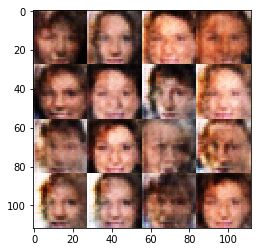

Epoch 1/1... Discriminator Loss: 1.3876... Generator Loss: 0.7327
Epoch 1/1... Discriminator Loss: 1.3962... Generator Loss: 0.7910
Epoch 1/1... Discriminator Loss: 1.3949... Generator Loss: 0.6946
Epoch 1/1... Discriminator Loss: 1.4012... Generator Loss: 0.7236
Epoch 1/1... Discriminator Loss: 1.3922... Generator Loss: 0.7907


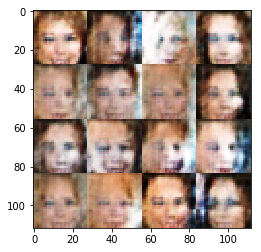

Epoch 1/1... Discriminator Loss: 1.4120... Generator Loss: 0.7196
Epoch 1/1... Discriminator Loss: 1.4322... Generator Loss: 0.7923
Epoch 1/1... Discriminator Loss: 1.4040... Generator Loss: 0.7155
Epoch 1/1... Discriminator Loss: 1.4018... Generator Loss: 0.8483
Epoch 1/1... Discriminator Loss: 1.3859... Generator Loss: 0.7974


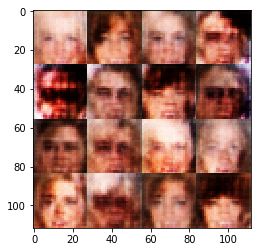

Epoch 1/1... Discriminator Loss: 1.4040... Generator Loss: 0.7669
Epoch 1/1... Discriminator Loss: 1.4140... Generator Loss: 0.7855
Epoch 1/1... Discriminator Loss: 1.4162... Generator Loss: 0.8329
Epoch 1/1... Discriminator Loss: 1.4276... Generator Loss: 0.7517
Epoch 1/1... Discriminator Loss: 1.3949... Generator Loss: 0.8369


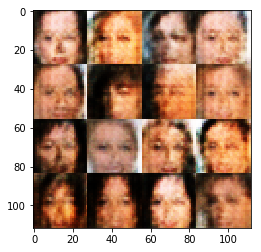

Epoch 1/1... Discriminator Loss: 1.3937... Generator Loss: 0.8002
Epoch 1/1... Discriminator Loss: 1.3967... Generator Loss: 0.7595
Epoch 1/1... Discriminator Loss: 1.3846... Generator Loss: 0.7855
Epoch 1/1... Discriminator Loss: 1.4103... Generator Loss: 0.8504
Epoch 1/1... Discriminator Loss: 1.3713... Generator Loss: 0.8128


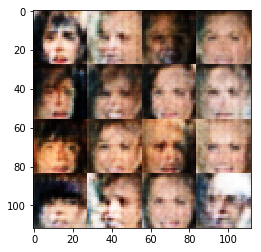

Epoch 1/1... Discriminator Loss: 1.3845... Generator Loss: 0.8086
Epoch 1/1... Discriminator Loss: 1.4051... Generator Loss: 0.7539
Epoch 1/1... Discriminator Loss: 1.3940... Generator Loss: 0.7359
Epoch 1/1... Discriminator Loss: 1.4266... Generator Loss: 0.8045
Epoch 1/1... Discriminator Loss: 1.3836... Generator Loss: 0.8052


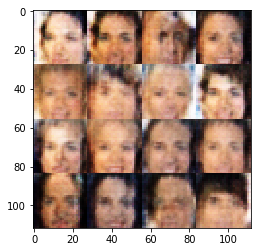

Epoch 1/1... Discriminator Loss: 1.4301... Generator Loss: 0.6597
Epoch 1/1... Discriminator Loss: 1.4167... Generator Loss: 0.7697
Epoch 1/1... Discriminator Loss: 1.3952... Generator Loss: 0.7524
Epoch 1/1... Discriminator Loss: 1.4026... Generator Loss: 0.7734
Epoch 1/1... Discriminator Loss: 1.3898... Generator Loss: 0.7698


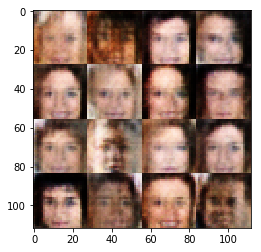

Epoch 1/1... Discriminator Loss: 1.4151... Generator Loss: 0.8360
Epoch 1/1... Discriminator Loss: 1.3892... Generator Loss: 0.8170
Epoch 1/1... Discriminator Loss: 1.4040... Generator Loss: 0.8428
Epoch 1/1... Discriminator Loss: 1.4139... Generator Loss: 0.7552
Epoch 1/1... Discriminator Loss: 1.3792... Generator Loss: 0.8297


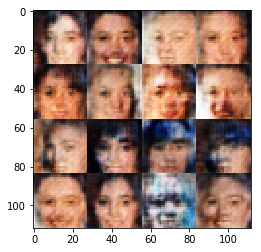

Epoch 1/1... Discriminator Loss: 1.3936... Generator Loss: 0.7783
Epoch 1/1... Discriminator Loss: 1.4077... Generator Loss: 0.7357
Epoch 1/1... Discriminator Loss: 1.4122... Generator Loss: 0.7279
Epoch 1/1... Discriminator Loss: 1.3923... Generator Loss: 0.7824
Epoch 1/1... Discriminator Loss: 1.4033... Generator Loss: 0.7502


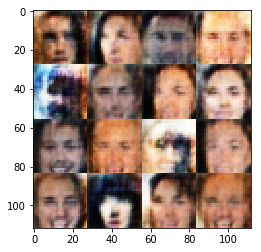

Epoch 1/1... Discriminator Loss: 1.3847... Generator Loss: 0.8528
Epoch 1/1... Discriminator Loss: 1.4182... Generator Loss: 0.6740
Epoch 1/1... Discriminator Loss: 1.3907... Generator Loss: 0.7245
Epoch 1/1... Discriminator Loss: 1.3939... Generator Loss: 0.7309
Epoch 1/1... Discriminator Loss: 1.3998... Generator Loss: 0.8220


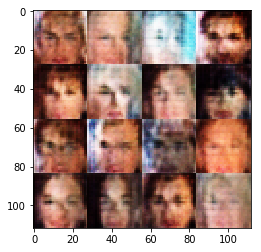

Epoch 1/1... Discriminator Loss: 1.4038... Generator Loss: 0.8065
Epoch 1/1... Discriminator Loss: 1.4172... Generator Loss: 0.7553
Epoch 1/1... Discriminator Loss: 1.4198... Generator Loss: 0.8877
Epoch 1/1... Discriminator Loss: 1.4039... Generator Loss: 0.8148
Epoch 1/1... Discriminator Loss: 1.3923... Generator Loss: 0.7686


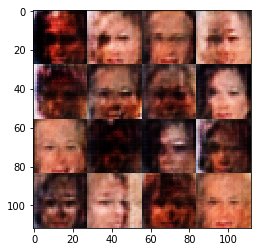

Epoch 1/1... Discriminator Loss: 1.4209... Generator Loss: 0.7647
Epoch 1/1... Discriminator Loss: 1.4426... Generator Loss: 0.8011
Epoch 1/1... Discriminator Loss: 1.4281... Generator Loss: 0.7041
Epoch 1/1... Discriminator Loss: 1.3982... Generator Loss: 0.7818
Epoch 1/1... Discriminator Loss: 1.4073... Generator Loss: 0.8136


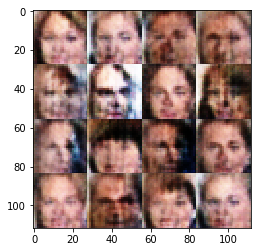

Epoch 1/1... Discriminator Loss: 1.3877... Generator Loss: 0.7547
Epoch 1/1... Discriminator Loss: 1.3958... Generator Loss: 0.7900
Epoch 1/1... Discriminator Loss: 1.3934... Generator Loss: 0.8136
Epoch 1/1... Discriminator Loss: 1.4116... Generator Loss: 0.7801
Epoch 1/1... Discriminator Loss: 1.4444... Generator Loss: 0.7228


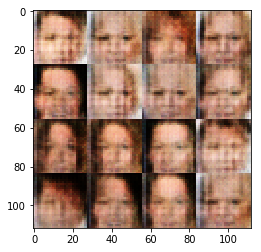

Epoch 1/1... Discriminator Loss: 1.4574... Generator Loss: 0.6267
Epoch 1/1... Discriminator Loss: 1.3747... Generator Loss: 0.7290
Epoch 1/1... Discriminator Loss: 1.3746... Generator Loss: 0.7449
Epoch 1/1... Discriminator Loss: 1.4099... Generator Loss: 0.6723
Epoch 1/1... Discriminator Loss: 1.4065... Generator Loss: 0.7201


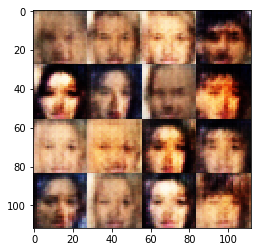

Epoch 1/1... Discriminator Loss: 1.4156... Generator Loss: 0.7268


In [13]:
batch_size = 64
z_dim = 100
learning_rate = 0.0005
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.